In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

---

# Loading Data

---

### Main Data File

In [3]:
data = pd.read_csv('data/sales_train.csv')
data.shape

(2935849, 6)

In [4]:
data.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


### Items Data

In [5]:
items = pd.read_csv('data/items.csv')
items.shape

(22170, 3)

In [6]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


### Item Categories Data

In [7]:
item_categories = pd.read_csv('data/item_categories.csv')
item_categories.shape

(84, 2)

In [8]:
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


### Shops Data

In [9]:
shops = pd.read_csv('data/shops.csv')
shops.shape

(60, 2)

In [10]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


<div class="alert alert-block alert-info">
- Dataset has 2.9 millions sales entries and 6 columns <br>
- There are 22k unique items referenced <br>
- There are 84 unique categories of items referenced <br>
- Products are distributed across 60 shops <br>

---

# Data Exploration

Definitions :
- Counts : number of distinct items with at least one unit sold on a day
- Volumes : Counts * nb of units sold (item_cnt_day ) 
- Sales : Volumes * Price

---

In [11]:
data['sales'] = data['item_price'] * data['item_cnt_day']

### Dates

In [12]:
data['date'] = pd.to_datetime(data['date'], format = "%d.%m.%Y")
data['date_m'] = data['date'].dt.strftime('%Y-%m')
data['date_d'] = data['date'].dt.strftime('%Y-%m-%d')

In [13]:
print(data['date'].min())
print(data['date'].max())

2013-01-01 00:00:00
2015-10-31 00:00:00


[Text(0.5, 0, '')]

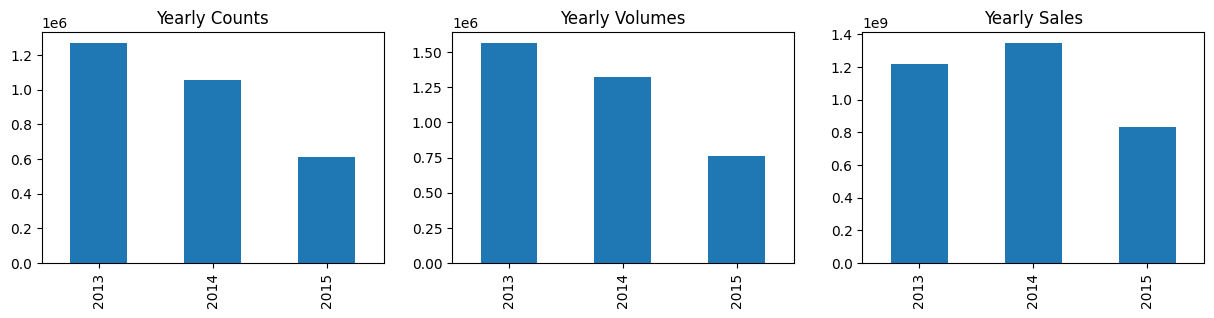

In [14]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,3))
# Yearly Counts
data['date'].dt.year.value_counts().plot.bar(ax = ax1)
ax1.set_title('Yearly Counts')
# Yearly Volumes
data.groupby(data['date'].dt.year).agg({'item_cnt_day':'sum'}).plot.bar(ax = ax2)
ax2.set_title('Yearly Volumes')
ax2.legend().set_visible(False)
ax2.set(xlabel=None)
data.groupby(data['date'].dt.year).agg({'sales':'sum'}).plot.bar(ax = ax3)
# Yearly Sales
ax3.set_title('Yearly Sales')
ax3.legend().set_visible(False)
ax3.set(xlabel=None)

<div class="alert alert-block alert-info">
- Dates range from Jan 2013 up to October 2015 <br>
- Volume trend is globally decreasing with time <br>
- Sales trend is not aligned with volume trend and has peak in 2014. <br>
- This decorrelation between Sales and Volumes could be explained either by a difference in the products sold or by a price evolution

[Text(0.5, 0, '')]

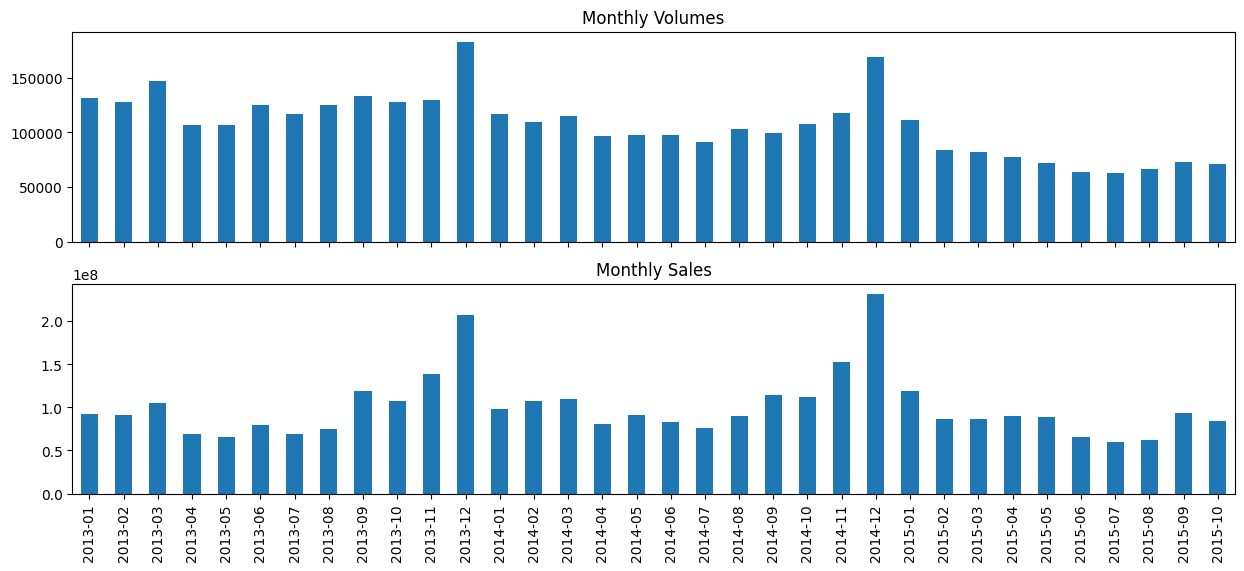

In [15]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,6))
# Monthly Volumes
data.groupby(data['date_m']).agg({'item_cnt_day':'sum'}).plot.bar(ax = ax1)
ax1.set_title('Monthly Volumes')
ax1.legend().set_visible(False)
ax1.set(xlabel=None)
# Monthly Sales
data.groupby(data['date_m']).agg({'sales':'sum'}).plot.bar(ax = ax2, sharex=ax1)
ax2.set_title('Monthly Sales')
ax2.legend().set_visible(False)
ax2.set(xlabel=None)

<div class="alert alert-block alert-info">
We can notice some seasonality with peak at year end <br>

[Text(0.5, 0, '')]

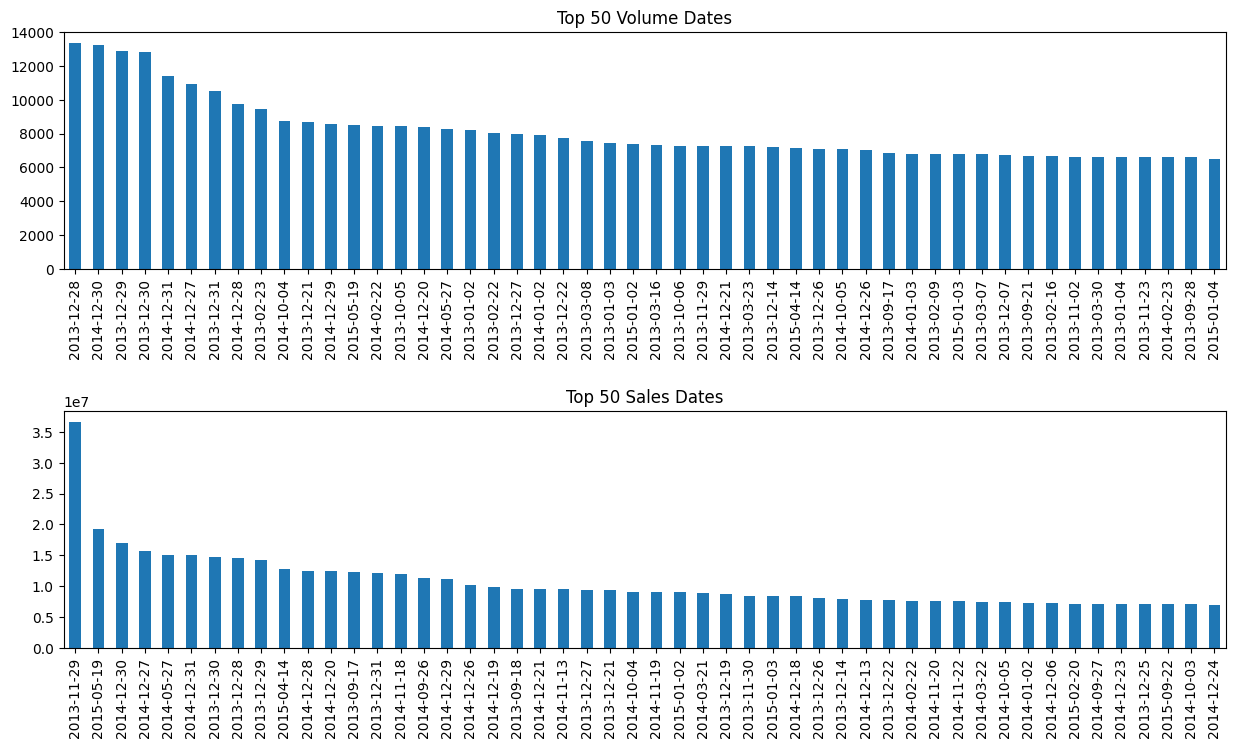

In [16]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,8))
fig.subplots_adjust(hspace=.6)
# Monthly Volumes
data.groupby(data['date_d']).agg({'item_cnt_day':'sum'}).sort_values(by = 'item_cnt_day', ascending = False).head(50).plot.bar(ax = ax1)
ax1.set_title('Top 50 Volume Dates')
ax1.legend().set_visible(False)
ax1.set(xlabel=None)
# Monthly Sales
data.groupby(data['date_d']).agg({'sales':'sum'}).sort_values(by = 'sales', ascending = False).head(50).plot.bar(ax = ax2)
ax2.set_title('Top 50 Sales Dates')
ax2.legend().set_visible(False)
ax2.set(xlabel=None)

<div class="alert alert-block alert-info">
Peak dates are mostly last days of the year<br>
29-11-2013 was an extreme high in sales

[Text(0.5, 0, '')]

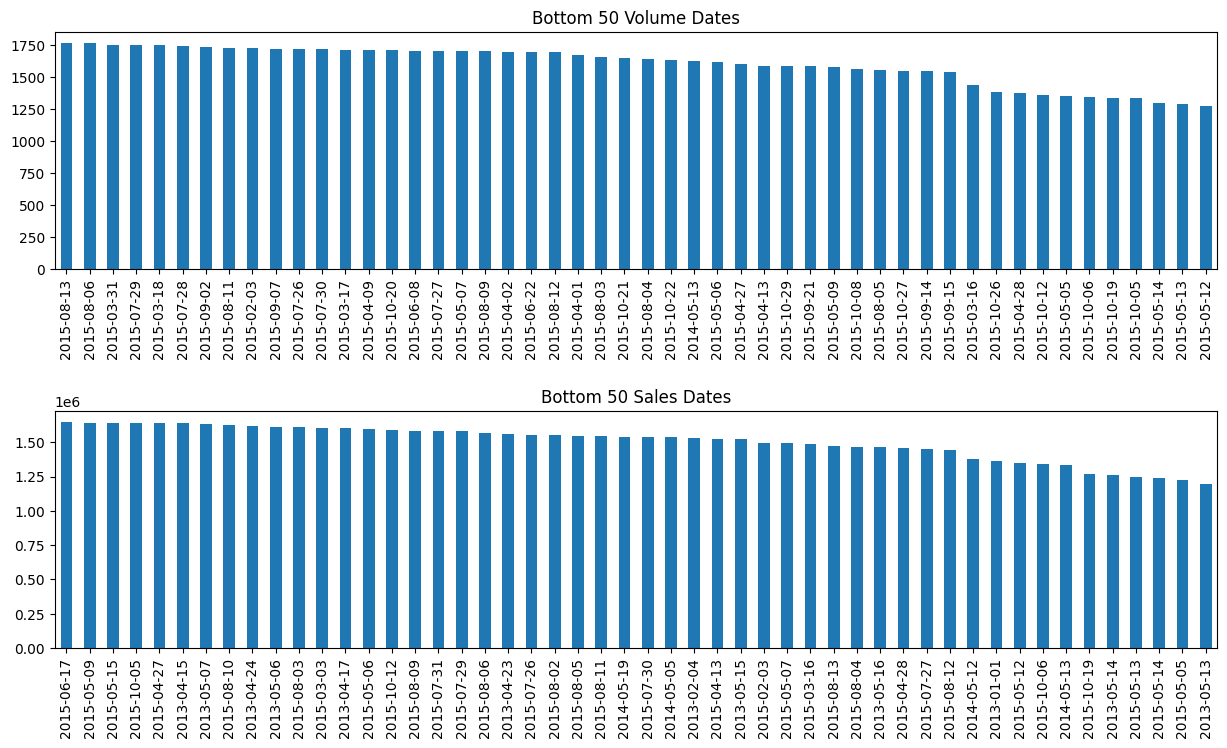

In [17]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,8))
fig.subplots_adjust(hspace=.6)
# Monthly Volumes
data.groupby(data['date_d']).agg({'item_cnt_day':'sum'}).sort_values(by = 'item_cnt_day', ascending = False).tail(50).plot.bar(ax = ax1)
ax1.set_title('Bottom 50 Volume Dates')
ax1.legend().set_visible(False)
ax1.set(xlabel=None)
# Monthly Sales
data.groupby(data['date_d']).agg({'sales':'sum'}).sort_values(by = 'sales', ascending = False).tail(50).plot.bar(ax = ax2)
ax2.set_title('Bottom 50 Sales Dates')
ax2.legend().set_visible(False)
ax2.set(xlabel=None)

### Shops

In [18]:
data['shop_id'].nunique()

60

[Text(0.5, 0, '')]

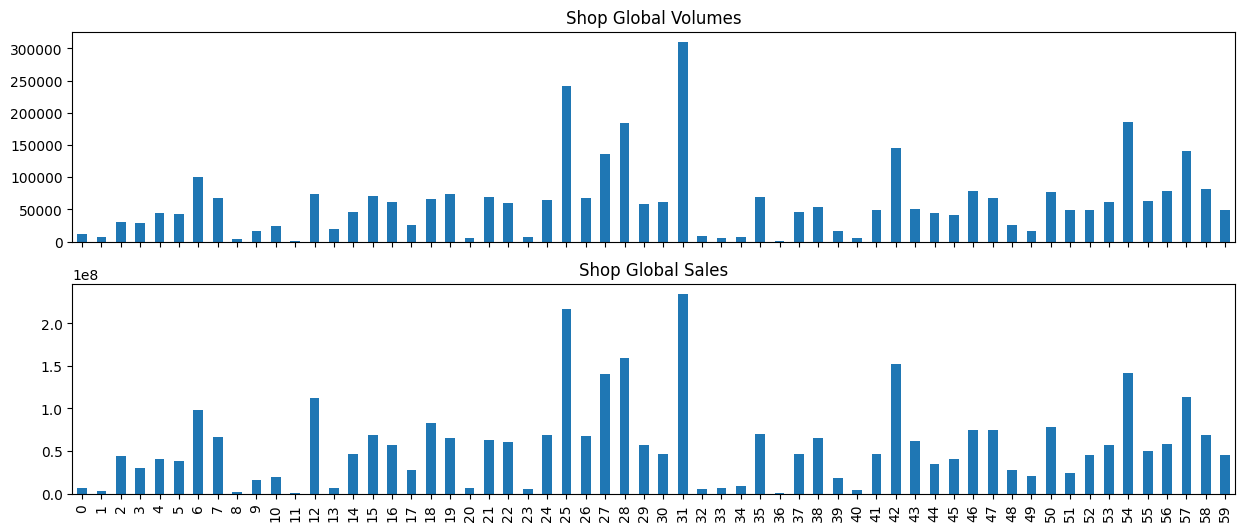

In [19]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,6))
# Shop Volumes
data.groupby('shop_id').agg({'item_cnt_day':'sum'}).plot.bar(ax = ax1)
ax1.set_title('Shop Global Volumes')
ax1.legend().set_visible(False)
ax1.set(xlabel=None)
# Shop Sales
data.groupby('shop_id').agg({'sales':'sum'}).plot.bar(ax = ax2, sharex=ax1)
ax2.set_title('Shop Global Sales')
ax2.legend().set_visible(False)
ax2.set(xlabel=None)

<div class="alert alert-block alert-info">
All 60 referenced shops are present in sales data <br>
There are strong discrepancies of volumes and sales between shops <br>

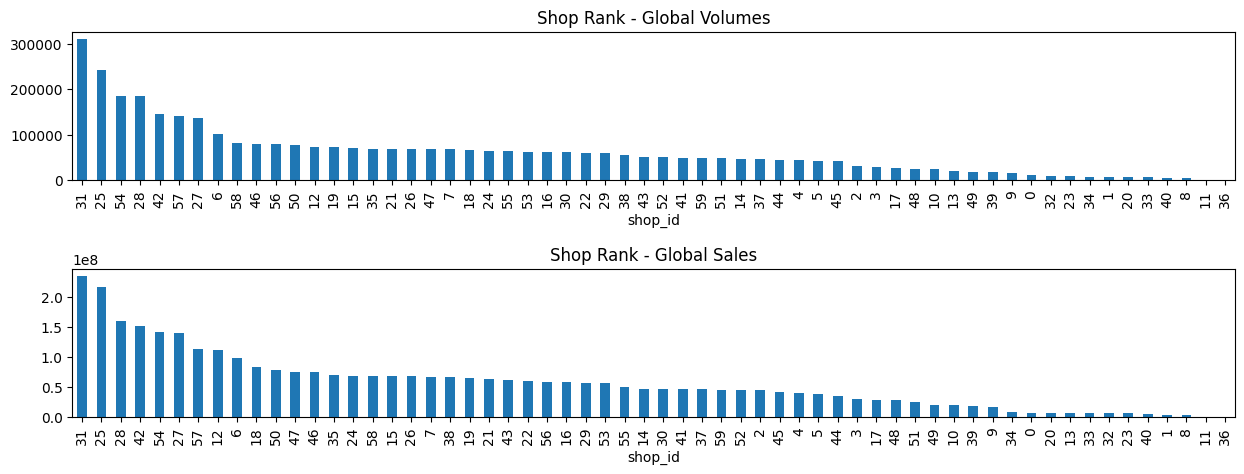

In [20]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,5))
fig.subplots_adjust(hspace=.6)
# Rank Global Volumes
data.groupby('shop_id').agg({'item_cnt_day':'sum'}).sort_values(by ='item_cnt_day', ascending=False).plot.bar(ax=ax1)
ax1.set_title('Shop Rank - Global Volumes')
ax1.legend().set_visible(False)
# Rank Monthly Volumes
data.groupby('shop_id').agg({'sales':'sum'}).sort_values(by ='sales', ascending=False).plot.bar(ax=ax2)
ax2.set_title('Shop Rank - Global Sales')
ax2.legend().set_visible(False)

<div class="alert alert-block alert-info">
We can notice some difference in the ranks in volume and sales <br>
It could be explained either by <br>
    - a difference in the products sold<br>
    - a difference in the pricing <br>
    - both

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,5))
fig.subplots_adjust(hspace=.6)
monthly_shop = data.groupby(['shop_id','date_block_num']).agg({'item_cnt_day':'sum','sales':'sum'})
# Rank Monthly Volumes
monthly_shop.groupby('shop_id').agg({'item_cnt_day':'mean'}).sort_values(by ='item_cnt_day', ascending=False).plot.bar(ax=ax1)
ax1.set_title('Shop Rank - Monthly Volumes')
ax1.legend().set_visible(False)
# Rank Monthly Sales
monthly_shop.groupby('shop_id').agg({'sales':'mean'}).sort_values(by ='sales', ascending=False).plot.bar(ax=ax2)
ax2.set_title('Shop Rank - Monthly Sales')
ax2.legend().set_visible(False)

<div class="alert alert-block alert-info">
Looking at the average monthly figures we can observe a few shops going up in the rank (shops 0,1,9 for instance) <br>
This is probably due to a difference in the number of months with sales between shops <br>

In [ ]:
f, ax = plt.subplots(figsize=(15,3))

# Shop Volumes
data.groupby(['shop_id']).agg({"date_block_num" : "nunique"}).plot.bar(ax=ax)
ax.legend().set_visible(False)
ax.set_title('Nb of sales months per Shop')

In [ ]:
# Shop Volumes
data.groupby(['shop_id']).agg({"date_block_num" : "nunique"})['date_block_num'].value_counts().sort_index(ascending = False)

<div class="alert alert-block alert-info">
Only half of the shops have sales records in all 34 months of observations <br>
10 shops have less than 10 months of data <br>
5 shops have less than 2 months of data <br>

### Items 

In [ ]:
data['item_id'].nunique()

In [ ]:
items['item_id'].nunique()

In [ ]:
missing_items = [items for items in items['item_id'].unique() if items not in data['item_id'].unique()]
len(missing_items) / items.shape[0]

<div class="alert alert-block alert-info">
1.5% of referenced items are not present in the data <br>